<a href="https://colab.research.google.com/github/serkansokmen/ml-workspace/blob/master/ML_Course_Week_04_Transfer_Learning_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial


In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

In [0]:
!rm -rf chest-xray-pneumonia.zip
!rm -rf chest_xray.zip
!rm -rf __MACOSX
!rm -rf kaggle.json

## Prepare and preprocess data

In [0]:
train_dir = 'chest_xray/train/'
validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

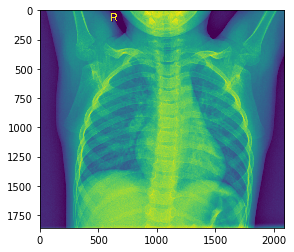

In [3]:
img = mpimg.imread(train_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

Visualize other images

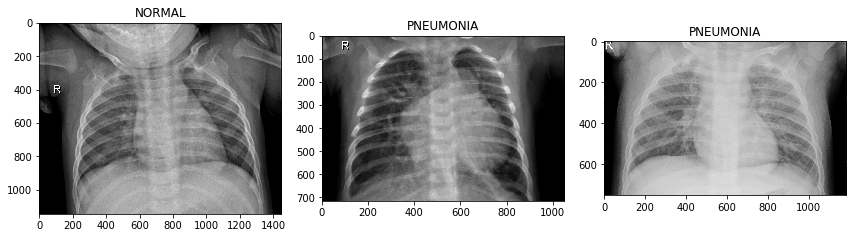

In [4]:
img_normal = plt.imread(f'{train_dir}NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread(f'{train_dir}PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread(f'{train_dir}PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

## Build the model using InceptionV3 as pre-trained model


In [25]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# pre_trained_model = InceptionV3(
#     input_shape=(150, 150, 3), include_top=False, weights=None)
# pre_trained_model.load_weights(local_weights_file)

# for layer in pre_trained_model.layers:
#   layer.trainable = False

  
# '''
# The layer we will use for feature extraction in Inception v3 is called mixed7. 
# It is not the bottleneck of the network, but we are using it to  keep a 
# sufficiently large feature map (7x7 in this case). (Using the bottleneck layer 
# would have resulting in a 3x3 feature map, which is a bit small.) Let's get the 
# output from mixed7
# '''

# last_layer = pre_trained_model.get_layer('mixed7')
# print(f'last layer output shape: {last_layer.output_shape}')
# last_output = last_layer.output

--2019-09-21 15:36:01--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  45.7MB/s    in 1.8s    

2019-09-21 15:36:03 (45.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape: (None, 7, 7, 768)


In [11]:
K.clear_session()

NUM_CLASSES = 2

# resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)


def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
#   x = BatchNormalization()(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

# predictions = Dense(NUM_CLASSES, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# with strategy.scope():
model = create_model((150, 150, 3))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Now we need to freeze all our base_model layers and train the last ones. An additional step can be performed after this initial training un-freezing some lower convolutional layers and retraining the classifier with a lower learning rate. This fine-tuning step increases the network accuracy but must be carefully carried out to avoid overfitting.

In [12]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2048, 1024) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(1024,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(1024, 512) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(512, 256) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(256, 128) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_4/kernel:0' shape=(128, 2) dtype=float32>,
 <tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32>]

Finally, we compile the model selecting the optimizer, the loss function, and the metric. In this case we are going to use a RMSProp optimizer with the default learning rate of 0.001, and a categorical_crossentropy — used in multiclass classification tasks — as loss function.

In [0]:
# with strategy.scope():
optimizer = Adam(lr=0.0001)
# optimizer = RMSprop(learning_rate=1e-3)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

## Data augmentation

In [16]:
# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=10,
#     validation_split=0.2,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     shear_range=0.05,
#     zoom_range=0.05,
#     horizontal_flip=True,
#     fill_mode='nearest')

train_datagen = ImageDataGenerator(featurewise_center=True,
                                   shear_range=0.2,
                                   rescale=1.0/255,
                                   horizontal_flip=True,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')
val_generator = test_datagen.flow_from_directory(validation_dir, 
                                                 target_size=(150, 150), 
                                                 batch_size=32, 
                                                 class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150), 
                                                  batch_size=32, 
                                                  class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


## Train the model

In [18]:
EPOCHS = 25
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64
MODEL_FILE = 'model.hd5'


# with strategy.scope():
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=EPOCHS,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

model.save(MODEL_FILE)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


163/163 [==============================] - 70s 432ms/step - loss: 0.4227 - acc: 0.8207 - val_loss: 1.9128 - val_acc: 0.5625
Epoch 2/25
163/163 [==============================] - 60s 371ms/step - loss: 0.2614 - acc: 0.8928 - val_loss: 0.9473 - val_acc: 0.6250
Epoch 3/25
163/163 [==============================] - 62s 378ms/step - loss: 0.2344 - acc: 0.9074 - val_loss: 0.9499 - val_acc: 0.7500
Epoch 4/25
163/163 [==============================] - 62s 382ms/step - loss: 0.2222 - acc: 0.9141 - val_loss: 0.8960 - val_acc: 0.8125
Epoch 5/25
163/163 [==============================] - 62s 379ms/step - loss: 0.2064 - acc: 0.9193 - val_loss: 1.8137 - val_acc: 0.5625
Epoch 6/25
163/163 [==============================] - 60s 371ms/step - loss: 0.1944 - acc: 0.9258 - val_loss: 1.1306 - val_acc: 0.8125
Epoch 7/25
163/163 [==============================] - 62s 378ms/step - loss: 0.2014 - acc: 0.9214 - val_loss: 1.8092 - val_acc: 0.6250
Epoch 8/25
163/163 [==============================] - 62s 379ms/st

## Model performance visualization over the epochs

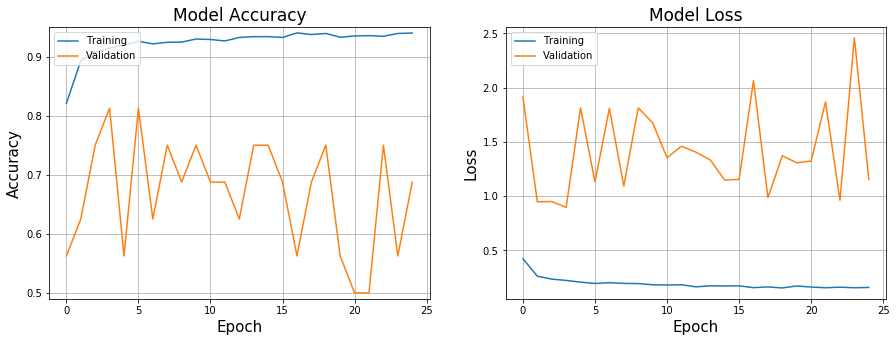

In [19]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

## Evaluate model

In [20]:
trained_model = tf.keras.models.load_model(MODEL_FILE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
result = trained_model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

20/20 [==============================] - 6s 282ms/step - loss: 1.0221 - acc: 0.6875
Loss     : 1.02  
Accuracy : 68.75%


In [22]:
y_pred = trained_model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

20/20 [==============================] - 7s 337ms/step


In [23]:
import random

numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = trained_model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 18
-----------------------------------
Batch Size              : 32
-----------------------------------
Accuracy                : 58.17%
-----------------------------------
